Au cours de ce projet d'analyse de données, nous allons traiter les données de la course du Vendée Globe, édition 2020.

Dans un premier temps, il s'agira d'importer les données relatives à la course, que l'on peut trouver sous forme de tableaux Excel et de pages HTML sur le site de la course. Nous effectuerons un premier nettoyage des classements intermédiaires en parallèle, avant de stocker celui-ci dans un dataframe global. Nous créerons aussi un tableau détaillant les caractéristiques des voiliers.

Nous nous intéresserons ensuite à certaines corrélations entre les données, avant de passer sur une partie visualisation de course. Pour chaque analyse, nous créerons une copie du dataframe original, sur lequel nous apporterons les modifications nécessaires.

In [419]:
import numpy as np
import pandas as pd
from shutil import copyfileobj
from urllib import request
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import requests
from bs4 import BeautifulSoup


# 1- Import des données

## 1.1- Import des classements intermédiaires


Nous nous arrêterons au classement du 27 janvier 2021 12h00, quelques heures avant l'arrivée du premier concurrent - Charlie Dalin (finalement détrôné par Yannick Bestaven suite à des bonifications) - aux Sables d'Olonne. 

Ainsi, en considérant la période du 8 novembre 2020 (départ) et le 27 janvier 2021, nos données de course seront constituées de 485 classements intermédiaires (plusieurs checkpoints par jour).

In [382]:
import uuid

import xlwings as xw

# lecture/écriture d'un fichier Excel avec xlwings
def save_with_xlwings(file):
    tempfile = './{uuid.uuid1()}.xlsx'
    excel_app = xw.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save(tempfile)
    excel_book.close()
    excel_app.quit()
    return tempfile

In [52]:
# Validation de l'import d'un seul fichier excel

url = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210101_040000.xlsx'
filename = 'exemple.xlsx'

with request.urlopen(url) as response, open(filename, 'wb') as out_file:
    copyfileobj(response, out_file)
exemple = save_with_xlwings('exemple.xlsx')

df = pd.read_excel(save_with_xlwings('exemple.xlsx'))


In [481]:
# fonction de nettoyage générique 

def clean_df(df) :

    date = df.iloc[1,1]
    df1 = df.copy()
    df1 = df1.drop(['Unnamed: 0'], axis = 1).drop([0,1], axis=0)
    
    row0 = df1.iloc[0].values
    row1 = df1.iloc[1].values

    columns_check = ['Rang', 'Voile', 'Skipper-bateau', 'Heure', 'Latitude', 'Longitude', 'Cap_30', 'Vitesse_30', 'VMG_30', 'Distance_30', 'Cap_last', 'Vitesse_last', 'VMG_last', 'Distance_last', 'Cap_day', 'Vitesse_day', 'VMG_day', 'Distance_day', 'DTF', 'DTL']
    df1 = df1.drop([2,3])
    df1 = df1.drop([37,38,39,40])
    df1.columns = columns_check
    df1.index = pd.RangeIndex(len(df1))
    df1.Voile = df1.Voile.apply(lambda x : str(x).replace(str('\n'), ''))
    df1.Heure = df1.Heure.apply(lambda x : str(x).replace(str('\n'), ''))
    df1['Skipper-bateau'] = df1['Skipper-bateau'].apply(lambda x : str(x).replace(str('\n'), ':'))
    return df1, date



Nous avons décidé d'aplatir l'index des colonnes pour plus de simplicité par rapport au format Excel : nous ajoutons alors un suffixe _30, _last ou _day aux attributs Cap, VMG et Vitesse.

In [459]:
url_vg = 'https://www.vendeeglobe.org/fr/classement'
r = requests.get(url_vg).content
#print(r.status_code)
soup = BeautifulSoup(r)
# print(soup)
select = soup.find('select', class_ = "form__input m--select onsubmit-rank")
checkpoints = []
for row in select :
    # print(str(row))
    checkpoints.append(str(row)[str(row).find('=') +2 : str(row).find('>')-1])

checkpoints = checkpoints[3: -1]

def generate_urls() :
    url_list = []
    base = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'
    extension = '.xlsx'
    for checkpoint in checkpoints :
        url_list.append(base + checkpoint + extension)
    return url_list


In [ ]:
url_list = generate_urls()

with open('url_list.pkl', 'wb') as file:

    pickle.dump(url_list, file)

In [136]:
# import des adresses url des checkpoints du début de course jusqu'au 27/01 14h (1ère arrivée)

with open('url_list.pkl', 'rb') as file:
	url_short = pickle.load(file)

url_short = url_short[220:-1]
print(url_short)


['https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210127_140000.xlsx', 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210127_110000.xlsx', 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210127_080000.xlsx', 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210127_040000.xlsx', 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210126_210000.xlsx', 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210126_170000.xlsx', 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210126_140000.xlsx', 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210126_110000.xlsx', 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210126_080000.xlsx', 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210126_040000.xlsx', 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210125_210000.xlsx', 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210125_170000.xlsx', 'ht

In [137]:
# Import, nettoyage et concaténation des fichiers de course

big_df = pd.DataFrame()
for i,url in enumerate(url_short) :
    filename = f'exemple{i}.xlsx'

    with request.urlopen(url) as response, open(filename, 'wb') as out_file:
        copyfileobj(response, out_file)
    clean, date = clean_df(pd.read_excel(save_with_xlwings(filename)))
    
    clean['Checkpoint'] = date
    big_df = pd.concat([big_df, clean])

big_df

    

,Rang,Voile,Skipper-bateau,Heure,Latitude,Longitude,Cap_30,Vitesse_30,VMG_30,Distance_30,...,Vitesse_last,VMG_last,Distance_last,Cap_day,Vitesse_day,VMG_day,Distance_day,DTF,DTL,Checkpoint
0,1,FRA 79,Charlie Dalin:APIVIA,14:30 FR,46°14.07'N,03°41.61'W,39°,21.0 kts,16.0 kts,10.5 nm,...,19.1 kts,17.4 kts,57.2 nm,61°,13.9 kts,13.9 kts,334.3 nm,80.5 nm,0.0 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
1,2,FRA 18,Louis Burton:Bureau Vallée 2,14:31 FR1min,46°24.62'N,05°11.90'W,116°,17.8 kts,15.6 kts,9.2 nm,...,17.7 kts,16.9 kts,53.3 nm,100°,17.2 kts,16.9 kts,412.1 nm,141.5 nm,60.9 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
2,3,MON 10,Boris Herrmann:Seaexplorer - Yacht Club De Monaco,14:30 FR,44°31.46'N,05°20.55'W,130°,18.2 kts,3.4 kts,9.1 nm,...,16.6 kts,10.3 kts,49.9 nm,84°,13.5 kts,12.9 kts,323.5 nm,190.0 nm,109.5 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
3,4,FRA 59,Thomas Ruyant:LinkedOut,14:30 FR,47°24.42'N,07°22.08'W,103°,17.6 kts,17.5 kts,8.8 nm,...,17.6 kts,17.6 kts,52.9 nm,93°,18.1 kts,18.0 kts,433.4 nm,235.8 nm,155.3 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
4,5,FRA 17,Yannick Bestaven:Maître Coq IV,14:30 FR,47°43.38'N,07°58.81'W,98°,18.4 kts,18.3 kts,9.2 nm,...,18.1 kts,18.1 kts,54.4 nm,91°,18.6 kts,18.6 kts,447.2 nm,264.3 nm,183.7 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,29,FRA 4,Sébastien Simon:ARKEA PAPREC,15:29 FR-1min,46°25.75'N,01°48.73'W,235°,13.4 kts,13.4 kts,0.7 nm,...,0.0 kts,0.0 kts,2789.3 nm,192°,0.2 kts,0.1 kts,4.5 nm,24295.5 nm,1.6 nm,Classement du dimanche 08 novembre 2020 à 16h0...
29,30,FRA 50,Miranda Merron:Campagne de France,15:28 FR-2min,46°25.39'N,01°48.34'W,237°,11.4 kts,11.3 kts,0.4 nm,...,0.0 kts,0.0 kts,2788.9 nm,188°,0.2 kts,0.2 kts,4.8 nm,24295.6 nm,1.7 nm,Classement du dimanche 08 novembre 2020 à 16h0...
30,31,FIN 222,Ari Huusela:Stark,15:30 FR,46°25.65'N,01°48.21'W,234°,12.1 kts,12.0 kts,0.2 nm,...,0.0 kts,0.0 kts,2789.1 nm,188°,0.2 kts,0.2 kts,4.6 nm,24295.8 nm,1.9 nm,Classement du dimanche 08 novembre 2020 à 16h0...
31,NL,FRA 79,Charlie Dalin:APIVIA,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Classement du dimanche 08 novembre 2020 à 16h0...


In [138]:
# Réindexation

big1 = big_df.copy()
big1.index = pd.RangeIndex(len(big1))



,Rang,Voile,Skipper-bateau,Heure,Latitude,Longitude,Cap_30,Vitesse_30,VMG_30,Distance_30,...,Vitesse_last,VMG_last,Distance_last,Cap_day,Vitesse_day,VMG_day,Distance_day,DTF,DTL,Checkpoint
0,1,FRA 79,Charlie Dalin:APIVIA,14:30 FR,46°14.07'N,03°41.61'W,39°,21.0 kts,16.0 kts,10.5 nm,...,19.1 kts,17.4 kts,57.2 nm,61°,13.9 kts,13.9 kts,334.3 nm,80.5 nm,0.0 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
1,2,FRA 18,Louis Burton:Bureau Vallée 2,14:31 FR1min,46°24.62'N,05°11.90'W,116°,17.8 kts,15.6 kts,9.2 nm,...,17.7 kts,16.9 kts,53.3 nm,100°,17.2 kts,16.9 kts,412.1 nm,141.5 nm,60.9 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
2,3,MON 10,Boris Herrmann:Seaexplorer - Yacht Club De Monaco,14:30 FR,44°31.46'N,05°20.55'W,130°,18.2 kts,3.4 kts,9.1 nm,...,16.6 kts,10.3 kts,49.9 nm,84°,13.5 kts,12.9 kts,323.5 nm,190.0 nm,109.5 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
3,4,FRA 59,Thomas Ruyant:LinkedOut,14:30 FR,47°24.42'N,07°22.08'W,103°,17.6 kts,17.5 kts,8.8 nm,...,17.6 kts,17.6 kts,52.9 nm,93°,18.1 kts,18.0 kts,433.4 nm,235.8 nm,155.3 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
4,5,FRA 17,Yannick Bestaven:Maître Coq IV,14:30 FR,47°43.38'N,07°58.81'W,98°,18.4 kts,18.3 kts,9.2 nm,...,18.1 kts,18.1 kts,54.4 nm,91°,18.6 kts,18.6 kts,447.2 nm,264.3 nm,183.7 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16000,29,FRA 4,Sébastien Simon:ARKEA PAPREC,15:29 FR-1min,46°25.75'N,01°48.73'W,235°,13.4 kts,13.4 kts,0.7 nm,...,0.0 kts,0.0 kts,2789.3 nm,192°,0.2 kts,0.1 kts,4.5 nm,24295.5 nm,1.6 nm,Classement du dimanche 08 novembre 2020 à 16h0...
16001,30,FRA 50,Miranda Merron:Campagne de France,15:28 FR-2min,46°25.39'N,01°48.34'W,237°,11.4 kts,11.3 kts,0.4 nm,...,0.0 kts,0.0 kts,2788.9 nm,188°,0.2 kts,0.2 kts,4.8 nm,24295.6 nm,1.7 nm,Classement du dimanche 08 novembre 2020 à 16h0...
16002,31,FIN 222,Ari Huusela:Stark,15:30 FR,46°25.65'N,01°48.21'W,234°,12.1 kts,12.0 kts,0.2 nm,...,0.0 kts,0.0 kts,2789.1 nm,188°,0.2 kts,0.2 kts,4.6 nm,24295.8 nm,1.9 nm,Classement du dimanche 08 novembre 2020 à 16h0...
16003,NL,FRA 79,Charlie Dalin:APIVIA,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Classement du dimanche 08 novembre 2020 à 16h0...


In [ ]:
# création du pickle

with open('big_df.pkl', 'wb') as file:
	pickle.dump(big1, file)

In [453]:
# chargement du pickle avec le dataframe complet

with open('big_df.pkl', 'rb') as file:
	df_complet = pickle.load(file)

df_complet.head(5)

,Rang,Voile,Skipper-bateau,Heure,Latitude,Longitude,Cap_30,Vitesse_30,VMG_30,Distance_30,...,Vitesse_last,VMG_last,Distance_last,Cap_day,Vitesse_day,VMG_day,Distance_day,DTF,DTL,Checkpoint
0,1,FRA 79,Charlie Dalin:APIVIA,14:30 FR,46°14.07'N,03°41.61'W,39°,21.0 kts,16.0 kts,10.5 nm,...,19.1 kts,17.4 kts,57.2 nm,61°,13.9 kts,13.9 kts,334.3 nm,80.5 nm,0.0 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
1,2,FRA 18,Louis Burton:Bureau Vallée 2,14:31 FR1min,46°24.62'N,05°11.90'W,116°,17.8 kts,15.6 kts,9.2 nm,...,17.7 kts,16.9 kts,53.3 nm,100°,17.2 kts,16.9 kts,412.1 nm,141.5 nm,60.9 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
2,3,MON 10,Boris Herrmann:Seaexplorer - Yacht Club De Monaco,14:30 FR,44°31.46'N,05°20.55'W,130°,18.2 kts,3.4 kts,9.1 nm,...,16.6 kts,10.3 kts,49.9 nm,84°,13.5 kts,12.9 kts,323.5 nm,190.0 nm,109.5 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
3,4,FRA 59,Thomas Ruyant:LinkedOut,14:30 FR,47°24.42'N,07°22.08'W,103°,17.6 kts,17.5 kts,8.8 nm,...,17.6 kts,17.6 kts,52.9 nm,93°,18.1 kts,18.0 kts,433.4 nm,235.8 nm,155.3 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR
4,5,FRA 17,Yannick Bestaven:Maître Coq IV,14:30 FR,47°43.38'N,07°58.81'W,98°,18.4 kts,18.3 kts,9.2 nm,...,18.1 kts,18.1 kts,54.4 nm,91°,18.6 kts,18.6 kts,447.2 nm,264.3 nm,183.7 nm,Classement du mercredi 27 janvier 2021 à 15h00 FR


## 1.2- Import des caractéristiques des voiliers

In [482]:
Cols = ['Voilier', 'Numéro de voile', 'Anciens noms du bateau', 'Architecte', 'Chantier', 'Date de lancement', 'Longueur', 'Largeur', "Tirant d'eau",'Déplacement (poids)', 'Nombre de dérives', 'Hauteur mât', 'Voile quille', 'Surface de voiles au près', 'Surface de voiles au portant']
url_boats = 'https://www.vendeeglobe.org/fr/glossaire'
df_boats = pd.DataFrame(columns=['Voilier', 'Numéro de voile', 'Anciens noms du bateau', 'Architecte', 'Chantier', 'Date de lancement', 'Longueur', 'Largeur', "Tirant d'eau",'Déplacement (poids)', 'Nombre de dérives', 'Hauteur mât', 'Voile quille', 'Surface de voiles au près', 'Surface de voiles au portant'])
df
r_boat = requests.get(url_boats).content
soup_boat = BeautifulSoup(r_boat)
#print(soup_boat)
select_boat = soup_boat.findAll('div', class_ = "boats-list__popup-infos")
#print(select_boat)
for boat in select_boat :
    list_char = []
    list_char.append(boat.find('h3').text)
    charact = boat.findAll('li')

    dico_char = {}
    for boat_char in charact :
        key_val = (boat_char.text).split(' : ')
        dico_char[key_val[0]] = key_val[1]

    for i, col in enumerate(Cols[1:]) :
        if col in dico_char :
            list_char.append(dico_char[col])
        else :
            list_char.append(None)
  
    df_boats.loc[len(df_boats.index)] = list_char

#print(df_boats)
df_boats = df_boats.drop(16)

df_boats = df_boats.replace('nc', None)
df_boats = df_boats.replace('NC', None)
df_boats['Déplacement (poids)'] = df_boats['Déplacement (poids)'].apply(lambda x : ','.join(re.findall("[0-9]",str(x))) if x !=None else x)
df_boats['Hauteur mât'] = df_boats['Hauteur mât'].apply(lambda x : ''.join(re.findall("[0-9+,]",str(x))) if x !=None else x)
df_boats['Surface de voiles au près'] = df_boats['Surface de voiles au près'].apply(lambda x : x[0:3])
df_boats['Surface de voiles au portant'] = df_boats['Surface de voiles au portant'].apply(lambda x : x[0:3])
df_boats['Longueur'] = df_boats['Longueur'].apply(lambda x : ''.join(re.findall("[0-9+,]",str(x))) if x !=None else x)
df_boats['Largeur'] = df_boats['Largeur'].apply(lambda x : ''.join(re.findall("[0-9+,]",str(x))) if x !=None else x)
df_boats["Tirant d'eau"] = df_boats["Tirant d'eau"].apply(lambda x : ''.join(re.findall("[0-9+,]",str(x))) if x !=None else x)
df_boats.head(5)


,Voilier,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28","5,85","4,50",7,foils,29,monotype,320,570
1,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28","5,80","4,50",9,2,28,acier forgé,280,560
2,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28","5,54","4,50",9,2,29,acier,260,580
3,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28","5,80","4,50",8,foils,29,acier mécano soudé,310,550
4,CHARAL,08,None,VPLP,CDK Technologies,18 Août 2018,"18,28","5,85","4,50",8,foils,29,acier,320,600


In [483]:
# reindexation à la main par manque de temps...

new_index = [10,6,18,26,3,27,24,21,13,30,32,9,1,4,5, 25,28,22, 17, 7,8, 23, 15,33]
df_boats_reindex = df_boats.copy()
df_boats_reindex.reindex(new_index)
df_boats_reindex.head(5)

,Voilier,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28","5,85","4,50",7,foils,29,monotype,320,570
1,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28","5,80","4,50",9,2,28,acier forgé,280,560
2,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28","5,54","4,50",9,2,29,acier,260,580
3,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28","5,80","4,50",8,foils,29,acier mécano soudé,310,550
4,CHARAL,08,None,VPLP,CDK Technologies,18 Août 2018,"18,28","5,85","4,50",8,foils,29,acier,320,600


La réindexation a pour but "d'aligner" le dataframe des caractéristiques de voiliers avec celui des concurrents, et de permettre ainsi de croiser ces caractéristiques avec les données de course.

Dans l'idéal, il aurait par exemple fallu réaliser une vraie jointure, mais les différences de format étaient pénibles à gérer.

# 2- Corrélation entre le classement (rang) et la vitesse utile (VMG) des voiliers

In [354]:
with open('skippers.pkl', 'rb') as file :
    skippers = pickle.load(file)

skippers

['Charlie Dalin:APIVIA',
 'Louis Burton:Bureau Vallée 2',
 'Boris Herrmann:Seaexplorer - Yacht Club De Monaco',
 'Thomas Ruyant:LinkedOut',
 'Yannick Bestaven:Maître Coq IV',
 'Damien Seguin:Groupe APICIL',
 'Giancarlo Pedote:Prysmian Group',
 'Jean Le Cam:Yes we Cam !',
 'Benjamin Dutreux:OMIA - Water Family',
 'Maxime Sorel:V And B Mayenne',
 "Armel Tripon:L'Occitane en Provence",
 'Clarisse Cremer:Banque Populaire X',
 'Romain Attanasio:Pure - Best Western Hotels and Resorts',
 'Jérémie Beyou:Charal',
 'Arnaud Boissieres:La Mie Câline - Artisans Artipôle',
 'Alan Roura:La Fabrique',
 'Kojiro Shiraishi:DMG MORI Global One',
 'Stéphane Le Diraison:Time For Oceans',
 'Pip Hare:Medallia',
 'Didac Costa:One Planet One Ocean',
 'Manuel Cousin:Groupe Sétin',
 'Miranda Merron:Campagne de France',
 'Clément Giraud:Compagnie du lit - Jiliti',
 'Alexia Barrier:TSE - 4myplanet',
 'Ari Huusela:Stark',
 'Sébastien Destremau:Merci',
 'Isabelle Joschke:MACSF',
 'Fabrice Amedeo:Newrest - Art et Fene

In [461]:
df_rang_VMG = df_complet.copy()
df_rang_VMG['VMG_last'] = df_rang_VMG['VMG_last'].apply(lambda x : float(''.join(re.findall("[0-9+.]",str(x))) if type(x) == str else 0))
df_rang_VMG['Vitesse_last'] = df_rang_VMG['Vitesse_last'].apply(lambda x : float(''.join(re.findall("[0-9+.]",str(x))) if type(x) == str else 0))
df_rang_VMG
dict_V_moy = {}
dict_VMG_moy = {}
for skipper in skippers :
    dict_VMG_moy[skipper] = df_rang_VMG.loc[df_rang_VMG['Skipper-bateau'] == skipper, ['VMG_last']].mean()[0]
    dict_V_moy[skipper] = df_rang_VMG.loc[df_rang_VMG['Skipper-bateau'] == skipper, ['Vitesse_last']].mean()[0]

print(dict_VMG_moy)
#print(df_rang_VMG)
    
class27_01 = {}
for k in range(33) :
    class27_01[df_rang_VMG.iloc[k,2]] = k + 1 if df_rang_VMG.iloc[k,0] != 'RET' else 'Abandon'

print(class27_01)

{'Charlie Dalin:APIVIA': 12.785360824742268, 'Louis Burton:Bureau Vallée 2': 12.838350515463919, 'Boris Herrmann:Seaexplorer - Yacht Club De Monaco': 12.774432989690723, 'Thomas Ruyant:LinkedOut': 12.685773195876289, 'Yannick Bestaven:Maître Coq IV': 12.713814432989688, 'Damien Seguin:Groupe APICIL': 12.646391752577319, 'Giancarlo Pedote:Prysmian Group': 12.634845360824741, 'Jean Le Cam:Yes we Cam !': 12.495051546391753, 'Benjamin Dutreux:OMIA - Water Family': 12.451546391752577, 'Maxime Sorel:V And B Mayenne': 12.287422680412373, "Armel Tripon:L'Occitane en Provence": 12.268041237113403, 'Clarisse Cremer:Banque Populaire X': 11.947422680412371, 'Romain Attanasio:Pure - Best Western Hotels and Resorts': 11.424329896907215, 'Jérémie Beyou:Charal': 11.810103092783505, 'Arnaud Boissieres:La Mie Câline - Artisans Artipôle': 11.081855670103094, 'Alan Roura:La Fabrique': 11.104948453608246, 'Kojiro Shiraishi:DMG MORI Global One': 10.981237113402061, 'Stéphane Le Diraison:Time For Oceans': 10

In [490]:
X1 = np.array([val for key, val in dict_VMG_moy.items()][:25])
Y1 = [val for key, val in class27_01.items()][:25]


On a fait attention à ne conserver que les skippers encore en course au 27 janvier, sinon le modèle serait faussé !

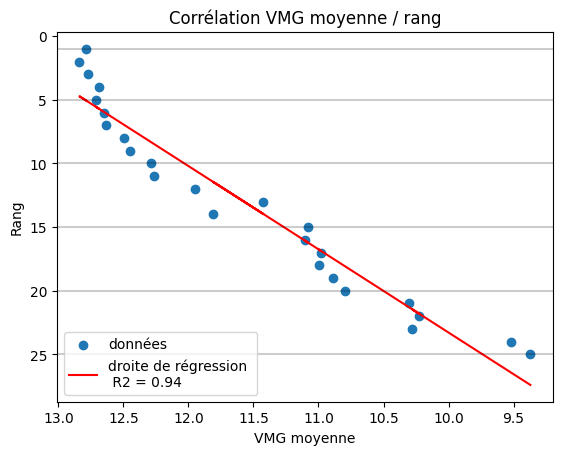

In [494]:
from sklearn.metrics import r2_score

modele_vmg = LinearRegression()
modele_vmg.fit(X1.reshape(-1,1),Y1)
r2 = r2_score(Y1, modele_vmg.predict(X1.reshape(-1,1)))
plt.scatter(X1,Y1, label = 'données')
plt.plot(X1, modele_vmg.predict(X1.reshape(-1,1)), label = f'droite de régression \n R2 = {np.round(r2,2)}', color = 'red')
plt.xlabel('VMG moyenne')
plt.ylabel('Rang')
plt.title('Corrélation VMG moyenne / rang')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
for y in range(5):
    plt.axhline(y=5*(y+1), color= 'black', alpha= 0.2)
plt.axhline(y=1, color= 'black', alpha= 0.2)
plt.legend()
plt.show()

Il est étonnant de constater que dans certains - rares - cas, des skippers devancent certains autres qui ont une VMG plus faible que la leur. La VMG étant la projection du vecteur vitesse effectif sur celui théorique, cela ne devrait pas arriver. Cela pourrait peut-être s'expliquer par les conditions météo... à moins que la meilleure route théorique soit déjà calculée en direct en fonction de la météo ; ou alors des erreurs dans les données.

## 2.2- Corrélation entre surface des voiles et vitesse moyenne

In [480]:
X_ = df_boats_reindex[['Surface de voiles au près', 'Surface de voiles au portant']][:25].to_numpy()

X = np.c_[np.ones((25, 1)), X_]
Y = [val for key, val in dict_V_moy.items()][:25]
modele_voile = LinearRegression().fit(X,Y)
theta = modele_voile.coef_
print(f'Paramètres de la régression : \n -> offset : {theta[0]}\n -> theta_au_près : {theta[1]} \n -> theta_au_portant : {theta[2]}')


Paramètres de la régression : 
 -> offset : 0.0
 -> theta_au_près : 0.001677742916181538 
 -> theta_au_portant : -0.004573977611801962


On aurait pu penser que la taille des voiles aurait une influence sur la vitesse moyenne des voiliers (peut-être car les skippers les plus aguerris savent maîtriser des voiles plus grandes), mais on constate que les deux variables de surface des voiles ne sont absolument pas significatives ! 



# 3- Distance parcourue par voilier du départ au 27 janvier 2022

In [163]:
df_skippers = df_complet.copy()
skippers = []
for k in range(33) :
    skippers.append(df_skippers.iloc[k,2])

skippers

with open('skippers.pkl', 'wb') as file :
    pickle.dump(skippers, file)


In [164]:
with open('skippers.pkl', 'rb') as file :
    skippers = pickle.load(file)

skippers

['Charlie Dalin:APIVIA',
 'Louis Burton:Bureau Vallée 2',
 'Boris Herrmann:Seaexplorer - Yacht Club De Monaco',
 'Thomas Ruyant:LinkedOut',
 'Yannick Bestaven:Maître Coq IV',
 'Damien Seguin:Groupe APICIL',
 'Giancarlo Pedote:Prysmian Group',
 'Jean Le Cam:Yes we Cam !',
 'Benjamin Dutreux:OMIA - Water Family',
 'Maxime Sorel:V And B Mayenne',
 "Armel Tripon:L'Occitane en Provence",
 'Clarisse Cremer:Banque Populaire X',
 'Romain Attanasio:Pure - Best Western Hotels and Resorts',
 'Jérémie Beyou:Charal',
 'Arnaud Boissieres:La Mie Câline - Artisans Artipôle',
 'Alan Roura:La Fabrique',
 'Kojiro Shiraishi:DMG MORI Global One',
 'Stéphane Le Diraison:Time For Oceans',
 'Pip Hare:Medallia',
 'Didac Costa:One Planet One Ocean',
 'Manuel Cousin:Groupe Sétin',
 'Miranda Merron:Campagne de France',
 'Clément Giraud:Compagnie du lit - Jiliti',
 'Alexia Barrier:TSE - 4myplanet',
 'Ari Huusela:Stark',
 'Sébastien Destremau:Merci',
 'Isabelle Joschke:MACSF',
 'Fabrice Amedeo:Newrest - Art et Fene

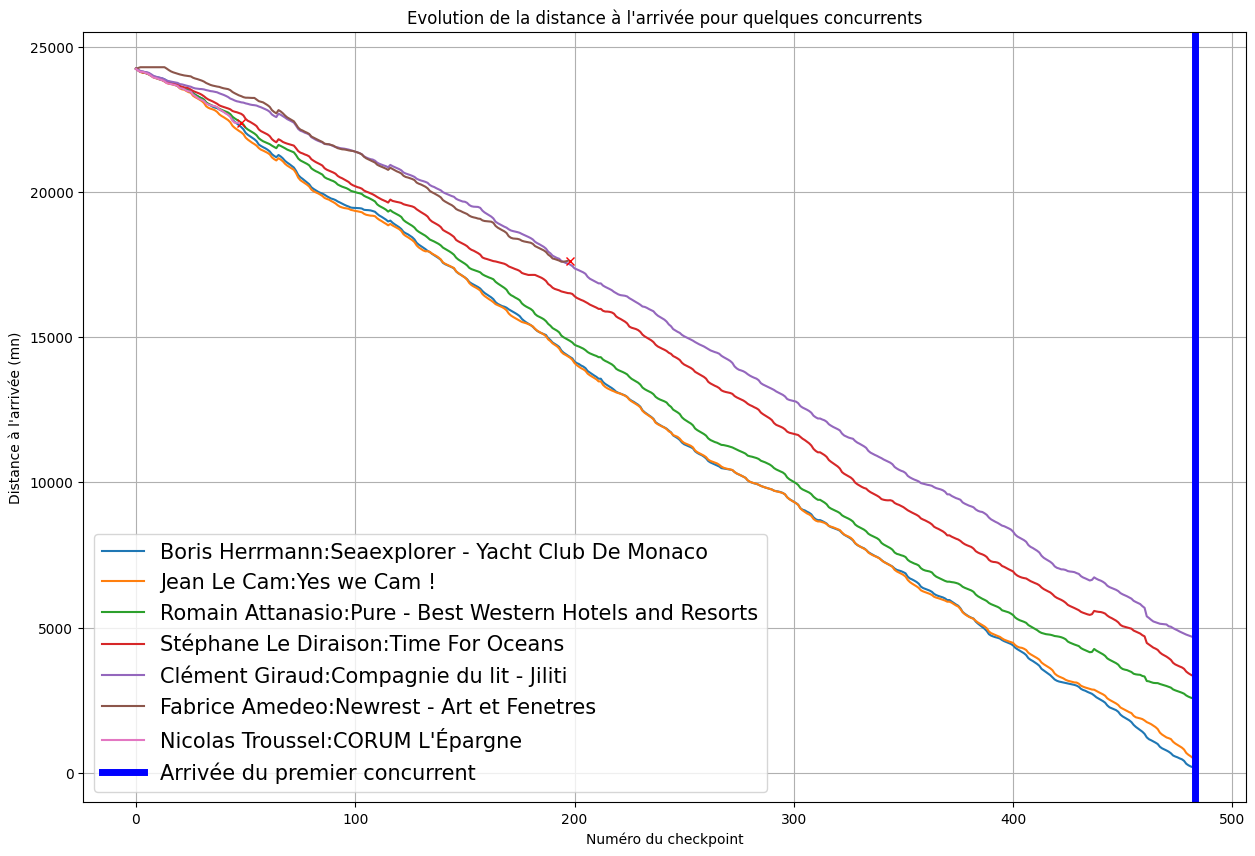

In [499]:
fig = plt.figure(figsize=(15,10))

df_complet1 = df_complet.copy()
list_DTFs = []
df_complet1['DTF'] = df_complet1['DTF'].apply(lambda x : float(''.join(re.findall("[0-9+.]",str(x))) if type(x) == str else 0))

for skipper in skippers[2::5] : 
    DTF_skipper = (df_complet1.loc[df_complet1['Skipper-bateau'] == skipper, ['DTF']].to_numpy())[::-1][2:]
    if 0 in DTF_skipper :
        abandon = np.where(DTF_skipper == 0)
        DTF_skipper = DTF_skipper[:abandon[0][0]] # on coupe au checkpoint où il y a eu abandon
        plt.plot(abandon[0][0],DTF_skipper[abandon[0][0]-1], 'x', color= 'red')
    list_DTFs.append(DTF_skipper)
        
    plt.plot(DTF_skipper, label = skipper)

plt.axvline(x = 483, color = 'b', linewidth= 5, label = 'Arrivée du premier concurrent')
    
plt.title("Evolution de la distance à l'arrivée pour quelques concurrents")
plt.legend(prop = {'size' : 15})
plt.grid()

plt.xlabel('Numéro du checkpoint')
plt.ylabel("Distance à l'arrivée (mn)")
plt.show()
#list_DTFs

-> Le classement évolue très peu au fil de la course.

-> Nous indiquons par une croix rouge les concurrents qui abandonnent.

# 4- Trajet des voiliers

In [319]:
def dms2dec(deg, mn, sec): # transformer les coordonnées gps DMS en décimal
    return deg + mn/60 + sec/3600


def coor_to_gps(coor) : # transformer une chaine de caractère en coordonnées gps DMS
    coor = coor.replace('°', ' ').replace('.',' ').replace("'", ' ').split(' ')
    if coor[3] == 'S' or coor[3] == 'W' :
        coor[0] = '-'+coor[0]
    coor = dms2dec(float(coor[0]), float(coor[1]), float(coor[2]))
    return coor

coor_to_gps("7°24.62'S")

def interpolate_gps(gps, n) : # tentative de rajout de points de passages fictifs pour améliorer la qualité de l'animation : pas terible finalement.
    gps_interp = []
    for i in range(len(gps[0:-1])):
        end = gps[i+1]
        print(end)
        start = gps[i]
        deltax = end[0]-start[0]
        deltay = end[1] - start[1]
        for k in range(n) :
            gps_interp.append([start[0] + k*deltax/n, start[1] +k*deltay/n])
        
    return gps_interp


In [341]:
# Traitement des séries d'intérêt : Latitude et Longitude


df_complet2 = df_complet.copy()

df_complet2['Latitude'] = df_complet2['Latitude'].apply(lambda x : coor_to_gps(x) if type(x) == str else 0)
df_complet2['Longitude'] = df_complet2['Longitude'].apply(lambda x : coor_to_gps(x) if type(x) == str else 0)
GPS_list = []
for skipper in skippers[:2] :
    Latitude = df_complet2.loc[df_complet2['Skipper-bateau'] == skipper, 'Latitude'].to_numpy()
    Longitude = df_complet2.loc[df_complet2['Skipper-bateau'] == skipper, 'Longitude'].to_numpy()
    
    gps = list(zip(Latitude, Longitude))[:-1][::-1]
    GPS_list.append(gps)
    




In [309]:
print(GPS_list)


[[[46.23527777777778, -2.299722222222222], [46.00000000000001, -2.4515000000000002], [45.764722222222225, -2.603277777777778], [45.52944444444445, -2.7550555555555563], [45.29416666666667, -2.906833333333334], [45.47638888888889, -3.476111111111111], [45.25833333333333, -3.6207222222222217], [45.04027777777778, -3.7653333333333325], [44.82222222222222, -3.9099444444444433], [44.60416666666667, -4.054555555555554], [44.75333333333334, -4.566388888888889], [44.618277777777784, -4.737833333333334], [44.483222222222224, -4.909277777777779], [44.34816666666667, -5.080722222222224], [44.21311111111112, -5.25216666666667], [43.89611111111111, -5.241666666666666], [43.52905555555556, -5.230777777777778], [43.162, -5.21988888888889], [42.79494444444445, -5.2090000000000005], [42.42788888888889, -5.198111111111112], [43.95055555555555, -7.076944444444444], [43.72622222222222, -7.1562777777777775], [43.501888888888885, -7.235611111111111], [43.27755555555555, -7.314944444444445], [43.053222222222

In [502]:
from ipyleaflet import Map, basemaps, AntPath, Marker, Icon, AwesomeIcon
import time

center = [38.128, 2.588]
zoom = 2

world_map = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)

n = len(GPS_list[0])
tracker_list = []
color_list = ['blue', 'red']


icon_list = []
for i, gps in enumerate(GPS_list) :
    icon_list.append(AwesomeIcon(name = 'anchor', marker_color= color_list[i], icon_color = 'black', spin= False))
    path = AntPath(locations= gps, color= color_list[i])
    world_map.add_layer(path)
    tracker_list.append(Marker(location=gps[0], icon = icon_list[i]))
    world_map.add_layer(tracker_list[i])
    


        

display(world_map)
#print(tracker_list)
for i in range(2, n-1):
    for k, tracker in enumerate(tracker_list) :
        #print(GPS_list[k][i])
        world_map.remove_layer(tracker)
        tracker = Marker(location=GPS_list[k][i], icon = icon_list[k])
        world_map.add_layer(tracker)
        tracker_list[k] = tracker
        time.sleep(0.2)
    




Map(center=[38.128, 2.588], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

KeyboardInterrupt: 

Nous représentons sur cette carte le chemin emprunté par Charlie Dalin (en bleu) et Louis Burton (en rouge). Lorsque l'animation se joue, les marqueurs avec une ancre avançent en fonction du temps, ce qui permet de représenter l'évolution de l'écart visuellement.

En modifiant la variables GPS, on peut représenter tous les concurrents que l'on souhaite.